# Time Stretching Using a Music AE

__Name:__  Noa Cahan <br>
__ID:__ 302208913 <br>
__TAU mail:__ cahan@mail.tau.ac.il<br>
__Gmail:__ noa.cahan@gmail.com <br>

In [1]:
import os
import sys
sys.path.append('..')
os.chdir('..')

import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import lws
import IPython.display as ipd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F 
import utils
import synthesis
import audio
import lws
import params
from model import AutoEncoder

%load_ext autoreload
%autoreload 2

## Abstract

Time stretching is the process of changing the duration of an audio signal without affecting its pitch.<br>
When using naive rate conversion or resampling, slowing down a recording lowers the pitch, speeding it up raises the pitch.<br><br>
Although many classical solution exists (in both time and frequency domain), to the best of my knowledge, there is no existing neural network that solves the time stretching problem.<br>

A neural network for time stretching is important for a number of reasons:

> 1. Deep learning on Music Information retrieval is an active area of research where there are still many tasks that are unexplored. As part of the task of obtaining better understanding of Music audio, time stretching is important.
 
> 2. The key importance of this model is as part of an end to end audio processing task. <br> An extended project will be to use neural networks to create a full phase vocoder application.
 
In the proposed method, time stretching will be implemented by scaling in time the encodings from a pre-trained autoencoder, and then adding a discriminator in order to force similarity between the scaled and original encodings. 

In this notebook I will present the model architecture, used dataset and generated examples and results.

## Chosen method for solving the problem

### The Model Description

I've made a few changes in the original plan for the model.<br>
Instead of trying to create a network that can be used as part of an end-to-end raw audio processing application, I tried to first solve a simplified version of the problem that will have a shorter training and inference time.<br>
In order to achieve this I've trained an extremely simple autoencoder on spectrogram images (rather than raw audio) on a smaller dataset (7.2 GiB).<br>
For the encoding manipulation, I’ve used a second network which in which I’ve used as a dataset, the encoding of the previous network stretched in different time lengths and corresponding encodings of a time-stretched signal from a phase vocoder.<br>
An illustration of the model described below:


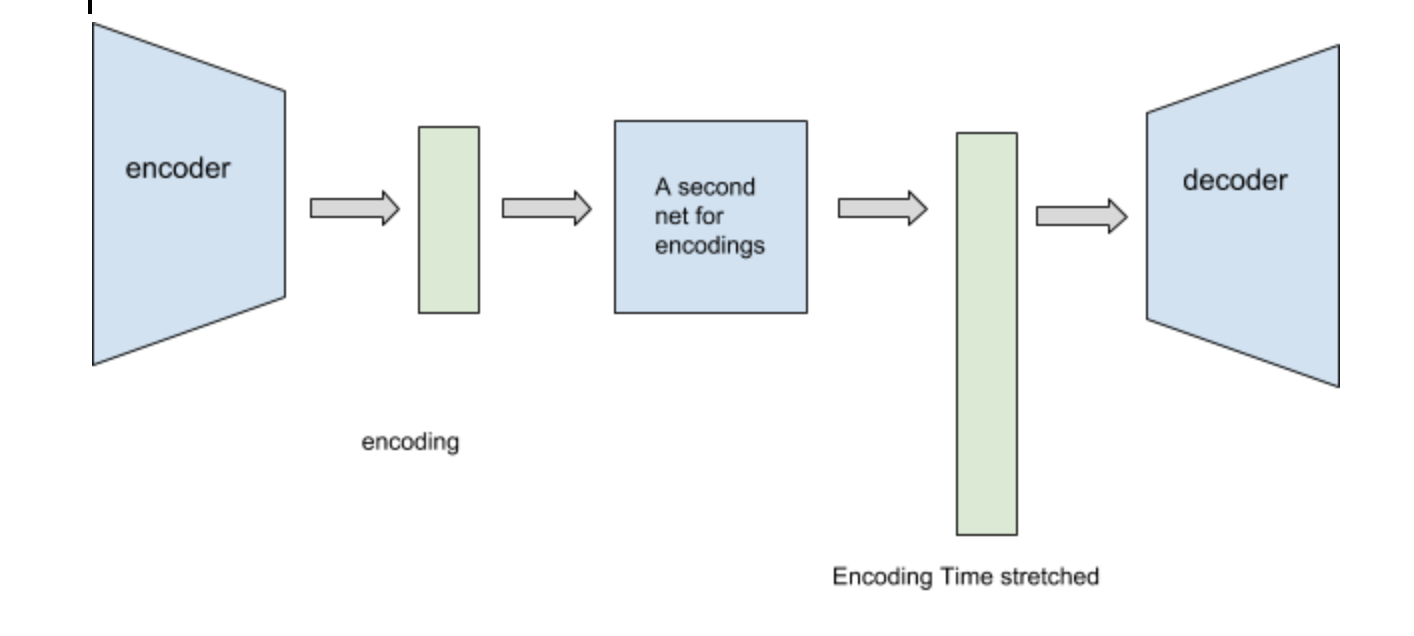

In [2]:
ipd.Image("./images/Model_new.png", width=700, height=700, embed=True)


### First Model Architecture:

In [3]:
class Layer(nn.Module):
    """
    A single layer of our very simple autoencoder
    """

    def __init__(self, in_size, out_size):
        super(Layer, self).__init__()
        self.linear = nn.Linear(in_size, out_size, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, inp):
        x = self.linear(inp)
        x = self.tanh(x)
        return x


class AutoEncoder(nn.Module):
    """
    A very simple autoencoder.  No bells, whistles, or convolutions
    """

    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            Layer(1025, 512),
            Layer(512, 256),
            Layer(256, 120))
        self.decoder = nn.Sequential(
            Layer(120, 256),
            Layer(256, 512),
            Layer(512, 1025))

    def forward(self, inp):
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded

### Second Model Architecture:

In [4]:
class TimeStretch(nn.Module):

    def __init__(self):
        super(TimeStretch, self).__init__()
        self.stretch = nn.Sequential(
            Layer(120, 300),
            Layer(300, 120))

    def forward(self, inp):
        stretched = self.stretch(inp)
        return stretched

### The Dataset I used:

Free Music Archive (FMA) - a dataset for music analysis.

FMA contains a small, medium and large dataset. 
I’ve trained the networks on the small one:

fma_small.zip: 8,000 tracks of 30s, 8 balanced genres (GTZAN-like) (7.2 GiB)
For training the autoencoder network:
The audio samples used were sliced to 3s parts and passed to the network as STFT spectrograms.

For training the second network:
Input: The encodings of the first network stretched to changing lengths: [0.25, 0.5, 1, 1.5, 2, 2.5]
Target: The librosa phase vocoder corresponding timestretched inputs 


### Training method

For the first network:

For training I've used Adam optimizer with learning rate of 1e-5 , batch size 128.
I’ve used a dual GPU machine.
Training took ~7 hours time to complete 500 epochs.

For the second network: 

For training I've used Adam optimizer with learning rate of 1e-4 , batch size 128.
I’ve used a dual GPU machine.
Network converged much faster after just a few epochs.

### Python packages I've used:

#### For Music features retrieval and phase vocoder:
http://librosa.github.io/librosa/

#### Fast Spectrogram phase recovery using Local Weighted Sums (LWS):
https://github.com/Jonathan-LeRoux/lws/tree/master/python

## Results:
 
### Learning Curves

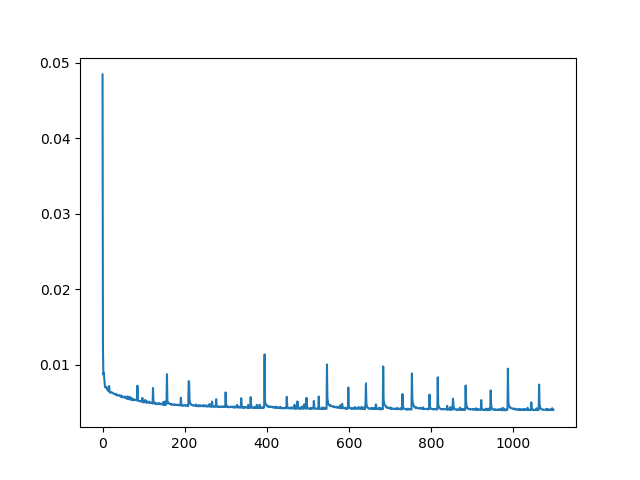

In [5]:
ipd.Image("./images/loss_gpu_AE200.png", width=500, height=500, embed=True)


## Results:

## 1. Encoding:

We'll now encode some audio using the pre-trained AutoEncoder model.<br>
This process is pretty fast, and doesn't even require to run on a GPU.
This will give us a 129 x 120 [T x F] dimension encoding for every 4 seconds of audio which we can then decode, or resynthesize.<br>
We'll try first to just leaving it alone and reconstructing it as is. Then we'll also try transformations of the encoding for time stretching.



In [11]:
orig = './samples/noa.wav'
orig = audio.load_wav(orig)
spec = audio.spectrogram(orig).astype(np.float32)
model_name = 'Autoencoder1.model' 
synthesis.encode(model_name, './samples/noa.wav', 'noa')
encoding = np.load('./encoding/noa.npy')
encoding = np.squeeze(encoding)

print(encoding.shape)
print(spec.shape)

(129, 120)
(1025, 129)


Let's take a look at the encoding of the spectrogram of the audio file and it's encoding:

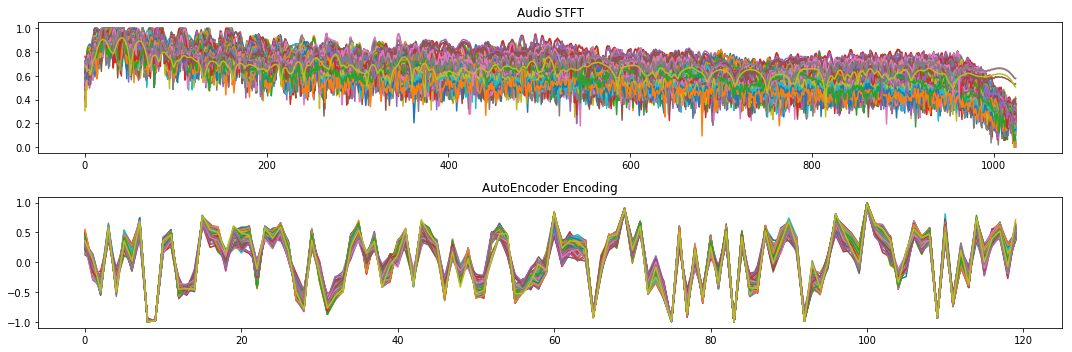

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(15, 5))
axs[0].plot(spec);
axs[0].set_title('Audio STFT')
axs[1].plot(encoding.T);
axs[1].set_title('AutoEncoder Encoding')
plt.savefig('./images/encoding.png')
plt.tight_layout()
plt.show()

## 2. Decoding:

We'll now decode the enbeddings as is.<br>
We can compare the original audio and the reconstructed one, in the spectrogram and the time domain.

In [17]:
synthesis.decode(model_name,'./encoding/noa.npy', 'noa_AE1' )
synthesis.spec_to_wav('./decoding/noa_AE1.npy' , './synthesis/noa_AE1.wav')
decoding = np.load('./decoding/noa_AE1.npy')
synth = audio.load_wav('./synthesis/noa_AE1.wav')
print(decoding.shape)

(129, 1025)


### 2.1. Model MSE Error:

The MSE error between the original and synthesised audio consistes from the model error and the error from the phase reconstruction. 

In [18]:
min_len = min(len(orig) , len(synth))
model_err = ((orig[:min_len] - synth[:min_len]) ** 2).mean()

print("Model Reconstruction MSE error: ", model_err)

Model Reconstruction MSE error:  0.0565399


### 2.1. STFT :

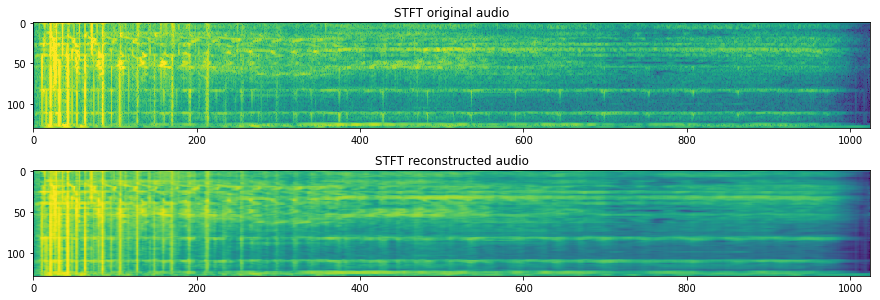

In [19]:
spec = audio.spectrogram(orig).astype(np.float32)
spec_after_net = decoding
spec_img = np.abs(spec.T)
spec_img_after_net = np.abs(spec_after_net)

plt.figure(figsize=(15, 5))
plt.subplot(2,1,1)
plt.imshow(spec_img)
plt.title('STFT original audio')
plt.subplot(2,1,2)
plt.imshow(spec_img_after_net)
plt.title('STFT reconstructed audio')
plt.savefig('./images/STFT.png')
plt.show()

### 2.2. Time Domain :

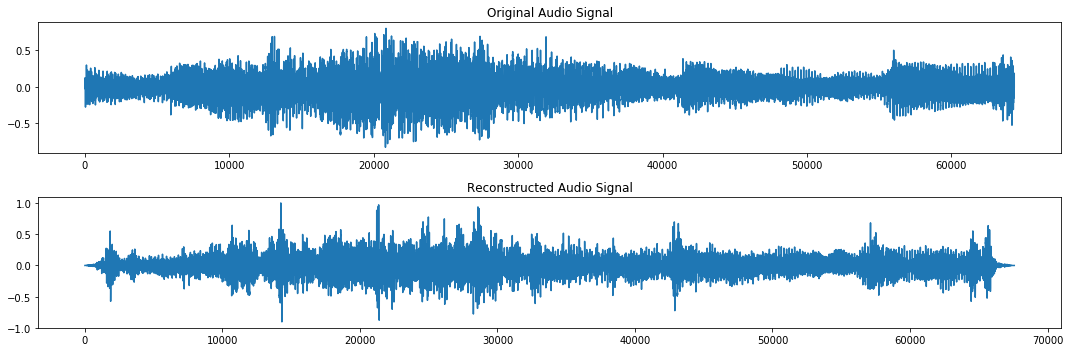

In [21]:
synth = audio.load_wav('./synthesis/noa_AE141.wav')
fig, axs = plt.subplots(2, 1, figsize=(15, 5))
axs[0].plot(orig);
axs[0].set_title('Original Audio Signal')
axs[1].plot(synth);
axs[1].set_title('Reconstructed Audio Signal')
plt.savefig('./images/Reconstructed_audio.png')
plt.tight_layout()
plt.show()

### Original audio & Reconstructed audio :

In [22]:
ipd.Audio(orig, rate=16000)

In [23]:
ipd.Audio(synth, rate=16000)

## 3. Time Stretching:

We'll now intepulate the embeddings.
As will be seen in the results below, trying to apply timestretching on the encoding as a simple interpulation causes pitch shifting in the resulted audio.

In [24]:
encoding_stretched_2 = utils.timestretch(encoding.T, 2.0)
encoding_stretched_0_5 = utils.timestretch(encoding.T, 0.5)

# save encodings
np.save('./encoding/noa_2.0.npy', encoding_stretched_2.T)
np.save('./encoding/noa_0_5.npy', encoding_stretched_0_5.T)

print( "stretched with factor 2: " , encoding_stretched_2.shape)
print( "stretched with factor 0.5: " , encoding_stretched_0_5.shape)
print("original encoding:", encoding.T.shape)

stretched with factor 2:  (120, 258)
stretched with factor 0.5:  (120, 64)
original encoding: (120, 129)


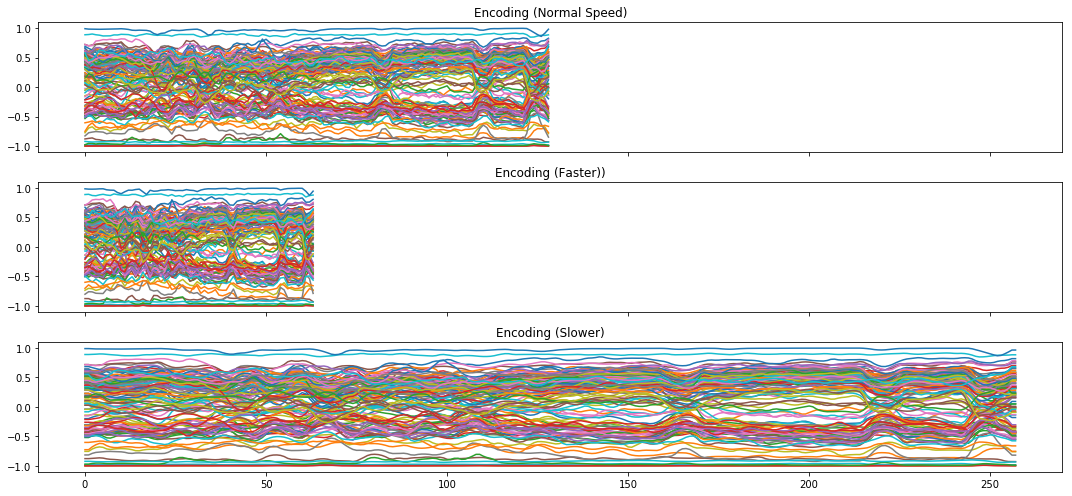

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(15, 7), sharex=True, sharey=True)
axs[0].plot(encoding); 
axs[0].set_title('Encoding (Normal Speed)')
axs[1].plot(encoding_stretched_0_5.T);
axs[1].set_title('Encoding (Faster))')
axs[2].plot(encoding_stretched_2.T);
axs[2].set_title('Encoding (Slower)')
plt.tight_layout()
plt.show()

In [26]:
# Decode
synthesis.decode(model_name,'./encoding/noa_2.0.npy', 'noa_AE1_2_0' )
synthesis.decode(model_name,'./encoding/noa_0_5.npy', 'noa_AE1_0_5' )

# Save wav
synthesis.spec_to_wav('./decoding/noa_AE1_2_0.npy' , './synthesis/noa_AE1_2_0.wav')
synthesis.spec_to_wav('./decoding/noa_AE1_0_5.npy' , './synthesis/noa_AE1_0_5.wav')

# Load decoded and wav
decoding2 = np.load('./decoding/noa_AE1_2_0.npy')
decoding0_5 = np.load('./decoding/noa_AE1_0_5.npy')

synth2 = audio.load_wav('./synthesis/noa_AE1_2_0.wav')
synth0_5 = audio.load_wav('./synthesis/noa_AE1_0_5.wav')


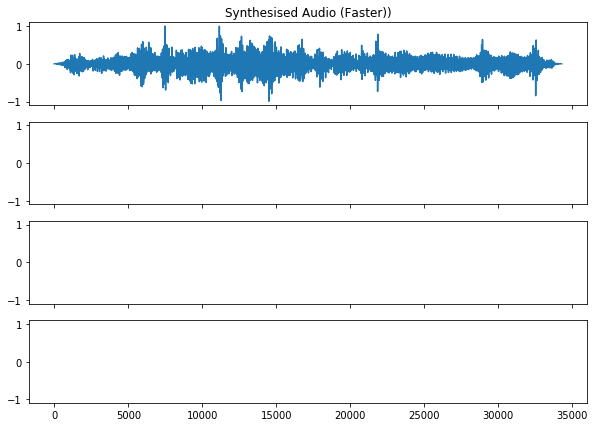

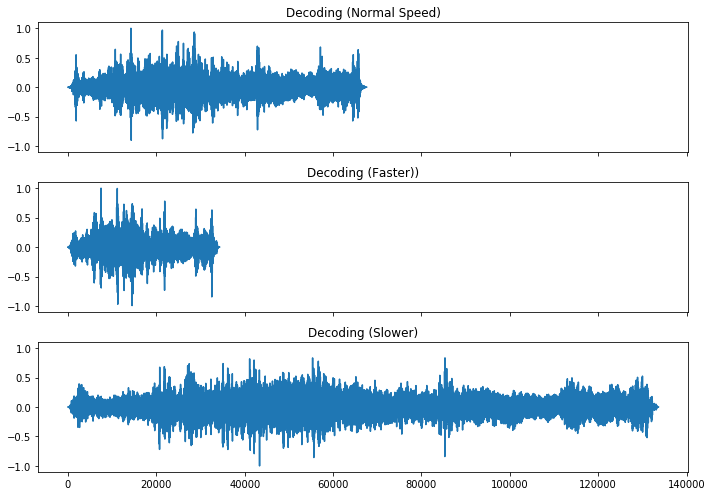

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey=True)
axs[0].plot(synth); 
axs[0].set_title('Decoding (Normal Speed)')
axs[1].plot(synth0_5);
axs[1].set_title('Decoding (Faster))')
axs[2].plot(synth2);
axs[2].set_title('Decoding (Slower)')
plt.savefig('./images/Reconstructed_audio_time_stretched.png')
plt.tight_layout()
plt.show()

Original Audio:

In [30]:
ipd.Audio(synth, rate=16000)

The slower Audio:

In [31]:
ipd.Audio(synth2, rate=16000)

The faster Audio:

In [32]:
ipd.Audio(synth0_5, rate=16000)

The pitch shift can be heard.

## 4. Compare to a Classical Phase Decoder:

We'll now compare the results to Librosa's phase decoder (which applies time stretching in the frequency domain).

### 4.1. Comparing Encodings
We will time stretch the original audio which is fed to the autoencoder and compare the encodings.

In [33]:
librosa_ts_2 = librosa.effects.time_stretch(orig, 2.0)
librosa_ts_0_5 = librosa.effects.time_stretch(orig, 0.5)

audio.save_wav(librosa_ts_2, './samples/librosa_noa_2_0.wav')
audio.save_wav(librosa_ts_0_5, './samples/librosa_noa_0_5.wav')

synthesis.encode(model_name, './samples/librosa_noa_2_0.wav', 'librosa_noa_2_0')
synthesis.encode(model_name, './samples/librosa_noa_0_5.wav', 'librosa_noa_0_5')

librosa_e_2 = np.load('./encoding/librosa_noa_2_0.npy')
librosa_e_0_5 = np.load('./encoding/librosa_noa_0_5.npy')

librosa_e_2 = np.squeeze(librosa_e_2)
librosa_e_0_5 = np.squeeze(librosa_e_0_5)

print(librosa_e_2.shape)
print(librosa_e_0_5.shape)
print(encoding_stretched_2.shape)
print(encoding_stretched_0_5.shape)

(65, 120)
(254, 120)
(120, 258)
(120, 64)


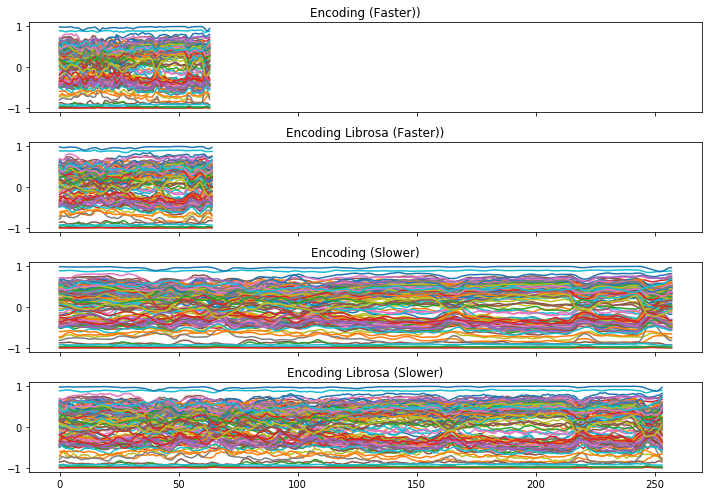

In [34]:
fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
axs[0].plot(encoding_stretched_0_5.T);
axs[0].set_title('Encoding (Faster))')
axs[1].plot(librosa_e_2);
axs[1].set_title('Encoding Librosa (Faster))')
axs[2].plot(encoding_stretched_2.T);
axs[2].set_title('Encoding (Slower)')
axs[3].plot(librosa_e_0_5);
axs[3].set_title('Encoding Librosa (Slower)')
plt.tight_layout()
plt.show()

Even here the frequency shift can be seen. 
For example: the red encoded frequncy in the image will be distorted in reconstruction.
We'll now decode then and see the results:

### 4.2. Comparing Results:
We will time stretch the synthesised audio (not the original) inorder to ignore the model's reconstruction error.

In [35]:
librosa_synth_ts_2 = librosa.effects.time_stretch(synth, 2.0)
librosa_synth_ts_0_5 = librosa.effects.time_stretch(synth, 0.5)

MSE error between phase vocoder and the synthesised audio: 

In [36]:
# Calculate MSE measure between then
min_len = min(len(librosa_synth_ts_0_5) , len(synth2))
ts_err = ((librosa_synth_ts_0_5[:min_len] - synth2[:min_len]) ** 2).mean()
print("MSE error after time stretching rate 2: " , ts_err)

min_len = min(len(librosa_synth_ts_2) , len(synth0_5))
ts_err = ((librosa_synth_ts_2[:min_len] - synth0_5[:min_len]) ** 2).mean()
print("MSE error after time stretching rate 2: " , ts_err)

MSE error after time stretching rate 2:  0.0357537
MSE error after time stretching rate 2:  0.0370658


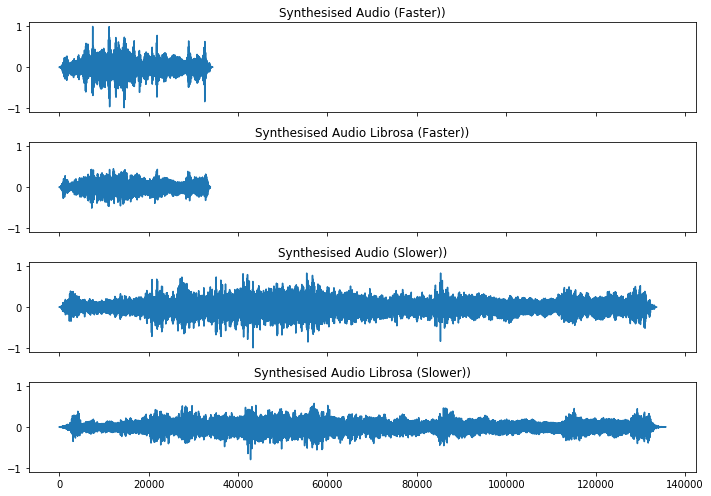

In [45]:
fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
axs[0].plot(synth0_5);
axs[0].set_title('Synthesised Audio (Faster))')
axs[1].plot(librosa_synth_ts_2);
axs[1].set_title('Synthesised Audio Librosa (Faster))')
axs[2].plot(synth2);
axs[2].set_title('Synthesised Audio (Slower))')
axs[3].plot(librosa_synth_ts_0_5);
axs[3].set_title('Synthesised Audio Librosa (Slower))')
plt.tight_layout()
plt.show()

## 5. Adding the second model:

Inorder to fix the pitch shift seen in the previous results i've added a second network.
This is the model:

## 5.1. Fixed Pitch Shift After adding another network:

Inorder to fix the pitch shift seen in the previous results i've added a second network.


In [46]:
ts_model_name = 'TimeStretch9.model'
encoding_stretched_2 = utils.timestretch(encoding.T, 2.0)
encoding_stretched_0_5 = utils.timestretch(encoding.T, 0.5)

# Encode
synthesis.transform_encode(ts_model_name, './encoding/noa_2.0.npy', 'noa_ts_2.0')
synthesis.transform_encode(ts_model_name, './encoding/noa_0_5.npy', 'noa_ts_0_5')
  
# Decode
synthesis.decode(model_name,'./encoding/noa_ts_2.0.npy', 'noa_AE1_TS1_2_0' )
synthesis.decode(model_name,'./encoding/noa_ts_0_5.npy', 'noa_AE_TS1_0_5' )

# Save wav
synthesis.spec_to_wav('./decoding/noa_AE1_TS1_2_0.npy' , './synthesis/noa_AE1_TS1_2_0.wav')
synthesis.spec_to_wav('./decoding/noa_AE_TS1_0_5.npy' , './synthesis/noa_AE1_TS1_0_5.wav')

# Load encoding decoded specs and wavs
encoding2_better = np.load('./decoding/noa_AE1_TS1_2_0.npy')
encoding0_5_better = np.load('./decoding/noa_AE_TS1_0_5.npy')

decoding2_better = np.load('./decoding/noa_AE1_TS1_2_0.npy')
decoding0_5_better = np.load('./decoding/noa_AE_TS1_0_5.npy')

synth2_better = audio.load_wav('./synthesis/noa_AE1_TS1_2_0.wav')
synth0_5_better = audio.load_wav('./synthesis/noa_AE1_TS1_0_5.wav')


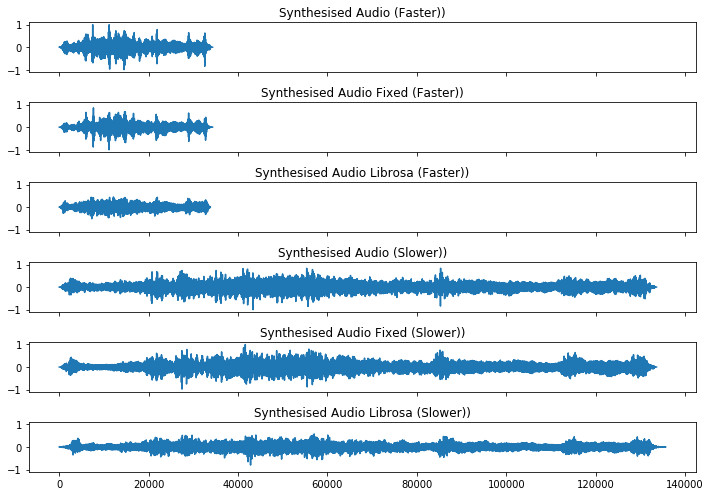

In [47]:
fig, axs = plt.subplots(6, 1, figsize=(10, 7), sharex=True, sharey=True)
axs[0].plot(synth0_5);
axs[0].set_title('Synthesised Audio (Faster))')
axs[1].plot(synth0_5_better);
axs[1].set_title('Synthesised Audio Fixed (Faster))')
axs[2].plot(librosa_synth_ts_2);
axs[2].set_title('Synthesised Audio Librosa (Faster))')
axs[3].plot(synth2);
axs[3].set_title('Synthesised Audio (Slower))')
axs[4].plot(synth2_better);
axs[4].set_title('Synthesised Audio Fixed (Slower))')
axs[5].plot(librosa_synth_ts_0_5);
axs[5].set_title('Synthesised Audio Librosa (Slower))')
plt.tight_layout()
plt.savefig('./images/Reconstructed_audio_time_stretched_after_fix.png')
plt.show()

Original Audio:

In [40]:
ipd.Audio(synth, rate=16000)

Slower Audio before fix:

In [41]:
ipd.Audio(synth2, rate=16000)

Slower Audio after fix:

In [42]:
ipd.Audio(synth2_better, rate=16000)

Slower Audio using librosa:

In [43]:
ipd.Audio(librosa_synth_ts_0_5, rate=16000)

Fast Audio before fix:

In [44]:
ipd.Audio(synth0_5, rate=16000)

Fast Audio after fix:

In [76]:
ipd.Audio(synth0_5_better, rate=16000)

Faster Audio using librosa:

In [77]:
ipd.Audio(librosa_synth_ts_2, rate=16000)

And when plotting Audio Signals:

MSE error between phase vocoder and the synthesised audio (Lower error than before): 

In [78]:
# Calculate MSE measure between then
min_len = min(len(librosa_synth_ts_2) , len(synth0_5_better))
ts_err = ((librosa_synth_ts_2[:min_len] - synth0_5_better[:min_len]) ** 2).mean()
print("MSE error after time stretching rate 2: " , ts_err)

min_len = min(len(librosa_synth_ts_0_5) , len(synth2_better))
ts_err = ((librosa_synth_ts_0_5[:min_len] - synth2_better[:min_len]) ** 2).mean()
print("MSE error after time stretching rate 2: " , ts_err)

MSE error after time stretching rate 2:  0.0306041
MSE error after time stretching rate 2:  0.0354915


## Further work

There is many more work to be done as part of an end-to-end  

## References

“STYLE” TRANSFER FOR MUSICAL AUDIO USING MULTIPLE TIME-FREQUENCY REPRESENTATIONS 2018. URL https://anonymousiclr2018.github.io/jekyll/update/2017/05/20/musical-style-transfer.html

"FMA: A Dataset for Music Analysis",
Defferrard, Michael and Benzi, Kirell and Vandergheynst, Pierre and Bresson, Xavier,
18th International Society for Music Information Retrieval Conference,2017, https://arxiv.org/abs/1612.01840

“Neural Audio Synthesis of Musical Notes with WaveNet Autoencoders” , 2017
Jesse Engel, Cinjon Resnick, Adam Roberts, Sander Dieleman, Douglas Eck, Karen Simonyan, Mohammad Norouzi
https://magenta.tensorflow.org/nsynth

Griffin Lim :
https://ieeexplore.ieee.org/document/1164317/

"Fast Signal Reconstruction from Magnitude {STFT} Spectrogram Based on Spectrogram Consistency",
Jonathan {Le Roux} and Hirokazu Kameoka and Nobutaka Ono and Shigeki Sagayama,
Proc. International Conference on Digital Audio Effects, sep 2010,397-403

An open source implementation of Deep Voice 3: Scaling Text-to-Speech with Convolutional Sequence Learning. 
Code:

https://github.com/r9y9/deepvoice3_pytorch

Audio texture synthesis and style transfer by Dmitry Ulyanov and Vadim Lebedev
 https://dmitryulyanov.github.io/audio-texture-synthesis-and-style-transfer/

